In [ ]:
!git clone https://github.com/myproject-01/penta_cancer.git

Cloning into 'penta_cancer'...
remote: Enumerating objects: 1676, done.
remote: Counting objects: 100% (1676/1676), done.
remote: Compressing objects: 100% (1495/1495), done.
^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_resource_variable_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export



In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		# store the image data format
		self.dataFormat = dataFormat

	def preprocess(self, image):
		# apply the Keras utility function that correctly rearranges
		# the dimensions of the image
		return img_to_array(image, data_format=self.dataFormat)

In [ ]:
# import the necessary packages
import imutils
import cv2

class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		# store the target image width, height, and interpolation
		# method used when resizing
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		# grab the dimensions of the image and then initialize
		# the deltas to use when cropping
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0

		# if the width is smaller than the height, then resize
		# along the width (i.e., the smaller dimension) and then
		# update the deltas to crop the height to the desired
		# dimension
		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		# otherwise, the height is smaller than the width so
		# resize along the height and then update the deltas
		# crop along the width
		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		# now that our images have been resized, we need to
		# re-grab the width and height, followed by performing
		# the crop
		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		# finally, resize the image to the provided spatial
		# dimensions to ensure our output image is always a fixed
		# size
		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")




In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_resource_variable_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

class SGD(optimizer_v2.OptimizerV2):
 
  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.01,
               momentum=0.0,
               nesterov=False,
               name="SGD",
               **kwargs):
    super(SGD, self).__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("decay", self._initial_decay)

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SGD, self)._prepare_local(var_device, var_dtype, apply_state)
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(
        self._get_hyper("momentum", var_dtype))

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self._momentum:
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceApplyKerasMomentum(
          var=var.handle,
          accum=momentum_var.handle,
          lr=coefficients["lr_t"],
          grad=grad,
          momentum=coefficients["momentum"],
          use_locking=self._use_locking,
          use_nesterov=self.nesterov)
    else:
      return gen_training_ops.ResourceApplyGradientDescent(
          var=var.handle,
          alpha=coefficients["lr_t"],
          delta=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse_duplicate_indices(self, grad, var, indices,
                                               **kwargs):
    if self._momentum:
      return super(SGD, self)._resource_apply_sparse_duplicate_indices(
          grad, var, indices, **kwargs)
    else:
      var_device, var_dtype = var.device, var.dtype.base_dtype
      coefficients = (kwargs.get("apply_state", {}).get((var_device, var_dtype))
                      or self._fallback_apply_state(var_device, var_dtype))

      return gen_resource_variable_ops.ResourceScatterAdd(
          resource=var.handle,
          indices=indices,
          updates=-grad * coefficients["lr_t"])

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    # This method is only needed for momentum optimization.
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    momentum_var = self.get_slot(var, "momentum")
    return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

  def get_config(self):
    config = super(SGD, self).get_config()
    config.update({
        "learning_rate": self._serialize_hyperparameter("learning_rate"),
        "decay": self._serialize_hyperparameter("decay"),
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
    })
    return config


from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

class Adam(optimizer_v2.OptimizerV2):
 

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-7,
               amsgrad=False,
               name='Adam',
               **kwargs):
    super(Adam, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Adam, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
          (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            epsilon=ops.convert_to_tensor_v2_with_dispatch(
                self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t))

  def set_weights(self, weights):
    params = self.weights
    # If the weights are generated by Keras V1 optimizer, it includes vhats
    # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
    # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(Adam, self).set_weights(weights)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')

    if not self.amsgrad:
      return gen_training_ops.ResourceApplyAdam(
          var=var.handle,
          m=m.handle,
          v=v.handle,
          beta1_power=coefficients['beta_1_power'],
          beta2_power=coefficients['beta_2_power'],
          lr=coefficients['lr_t'],
          beta1=coefficients['beta_1_t'],
          beta2=coefficients['beta_2_t'],
          epsilon=coefficients['epsilon'],
          grad=grad,
          use_locking=self._use_locking)
    else:
      vhat = self.get_slot(var, 'vhat')
      return gen_training_ops.ResourceApplyAdamWithAmsgrad(
          var=var.handle,
          m=m.handle,
          v=v.handle,
          vhat=vhat.handle,
          beta1_power=coefficients['beta_1_power'],
          beta2_power=coefficients['beta_2_power'],
          lr=coefficients['lr_t'],
          beta1=coefficients['beta_1_t'],
          beta2=coefficients['beta_2_t'],
          epsilon=coefficients['epsilon'],
          grad=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    # m_t = beta1 * m + (1 - beta1) * g_t
    m = self.get_slot(var, 'm')
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([m_t]):
      m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

    # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
    v = self.get_slot(var, 'v')
    v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
    v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([v_t]):
      v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

    if not self.amsgrad:
      v_sqrt = math_ops.sqrt(v_t)
      var_update = state_ops.assign_sub(
          var, coefficients['lr'] * m_t / (v_sqrt + coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t])
    else:
      v_hat = self.get_slot(var, 'vhat')
      v_hat_t = math_ops.maximum(v_hat, v_t)
      with ops.control_dependencies([v_hat_t]):
        v_hat_t = state_ops.assign(
            v_hat, v_hat_t, use_locking=self._use_locking)
      v_hat_sqrt = math_ops.sqrt(v_hat_t)
      var_update = state_ops.assign_sub(
          var,
          coefficients['lr'] * m_t / (v_hat_sqrt + coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t, v_hat_t])

  def get_config(self):
    config = super(Adam, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
    })
    return config


class NonFusedAdam(optimizer_v2.OptimizerV2):


  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-7,
               amsgrad=False,
               name='Adam',
               **kwargs):
   
    super(NonFusedAdam, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad

  def _create_slots(self, var_list):
    # Create slots for the first and second moments.
    # Separate for-loops to respect the ordering of slot variables from v1.
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(NonFusedAdam, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (
        apply_state[(var_device, var_dtype)]['lr_t'] *
        (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            epsilon=ops.convert_to_tensor_v2_with_dispatch(
                self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t))

  def set_weights(self, weights):
    params = self.weights
    # If the weights are generated by Keras V1 optimizer, it includes vhats
    # even without amsgrad, i.e, V1 optimizer has 3x + 1 variables, while V2
    # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(NonFusedAdam, self).set_weights(weights)

  @def_function.function(experimental_compile=True)
  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')

    alpha = (
        coefficients['lr_t'] * math_ops.sqrt(1 - coefficients['beta_2_power']) /
        (1 - coefficients['beta_1_power']))
    m.assign_add((grad - m) * (1 - coefficients['beta_1_t']))
    v.assign_add((math_ops.square(grad) - v) * (1 - coefficients['beta_2_t']))
    if self.amsgrad:
      vhat = self.get_slot(var, 'vhat')
      vhat.assign(math_ops.maximum(vhat, v))
      v = vhat
    var.assign_sub(
        (m * alpha) / (math_ops.sqrt(v) - coefficients['epsilon']))

  @def_function.function(experimental_compile=True)
  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype)) or
                    self._fallback_apply_state(var_device, var_dtype))

    # m_t = beta1 * m + (1 - beta1) * g_t
    m = self.get_slot(var, 'm')
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m.assign(m * coefficients['beta_1_t'])
    m.scatter_add(ops.IndexedSlices(m_scaled_g_values, indices))

    # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
    v = self.get_slot(var, 'v')
    v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
    v.assign(v * coefficients['beta_2_t'])
    v.scatter_add(ops.IndexedSlices(v_scaled_g_values, indices))

    if not self.amsgrad:
      var.assign_sub(coefficients['lr'] * m /
                     (math_ops.sqrt(v) + coefficients['epsilon']))
    else:
      v_hat = self.get_slot(var, 'vhat')
      v_hat.assign(math_ops.maximum(v_hat, v))
      var.assign_sub(coefficients['lr'] * m /
                     (math_ops.sqrt(v_hat) + coefficients['epsilon']))

  def get_config(self):
    config = super(NonFusedAdam, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
    })
    return config

In [ ]:

 
class VGG16:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model


In [ ]:
# import the necessary packages
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		# store the image preprocessor
		self.preprocessors = preprocessors

		# if the preprocessors are None, initialize them as an
		# empty list
		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		# initialize the list of features and labels
		data = []
		labels = []

		# loop over the input images
		for (i, imagePath) in enumerate(imagePaths):
			# load the image and extract the class label assuming
			# that our path has the following format:
			# /path/to/dataset/{class}/{image}.jpg
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			# check to see if our preprocessors are not None
			if self.preprocessors is not None:
				# loop over the preprocessors and apply each to
				# the image
				for p in self.preprocessors:
					image = p.preprocess(image)

			# treat our processed image as a "feature vector"
			# by updating the data list followed by the labels
			data.append(image)
			labels.append(label)

			# show an update every `verbose` images
			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		# return a tuple of the data and labels
		return (np.array(data), np.array(labels))

In [ ]:
# grab the list of images that we'll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
imagePaths = list(paths.list_images("drive/MyDrive/penta_dataset/"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

# initialize the image preprocessors
aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities to
# the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=100)
data = data.astype("float") / 255.0


[INFO] loading images...
[INFO] processed 100/2863
[INFO] processed 200/2863
[INFO] processed 300/2863
[INFO] processed 400/2863
[INFO] processed 500/2863
[INFO] processed 600/2863
[INFO] processed 700/2863
[INFO] processed 800/2863
[INFO] processed 900/2863
[INFO] processed 1000/2863
[INFO] processed 1100/2863
[INFO] processed 1200/2863
[INFO] processed 1300/2863
[INFO] processed 1400/2863
[INFO] processed 1500/2863
[INFO] processed 1600/2863
[INFO] processed 1700/2863
[INFO] processed 1800/2863
[INFO] processed 1900/2863
[INFO] processed 2000/2863
[INFO] processed 2100/2863
[INFO] processed 2200/2863
[INFO] processed 2300/2863
[INFO] processed 2400/2863
[INFO] processed 2500/2863
[INFO] processed 2600/2863
[INFO] processed 2700/2863
[INFO] processed 2800/2863


In [ ]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)





[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
67/67 [==============================] - 66s 509ms/step - loss: 1.6822 - accuracy: 0.5603 - val_loss: 6.7599 - val_accuracy: 0.1187
Epoch 2/20
67/67 [==============================] - 32s 480ms/step - loss: 0.8196 - accuracy: 0.7047 - val_loss: 7.4289 - val_accuracy: 0.2137
Epoch 3/20
67/67 [==============================] - 32s 480ms/step - loss: 0.7128 - accuracy: 0.7493 - val_loss: 6.0396 - val_accuracy: 0.2556
Epoch 4/20
67/67 [==============================] - 32s 488ms/step - loss: 0.5849 - accuracy: 0.7888 - val_loss: 5.8158 - val_accuracy: 0.2472
Epoch 5/20
67/67 [==============================] - 32s 477ms/step - loss: 0.4759 - accuracy: 0.8200 - val_loss: 6.3775 - val_accuracy: 0.2891
Epoch 6/20
67/67 [==============================] - 32s 481ms/step - loss: 0.5110 - accuracy: 0.8237 - val_loss: 4.6267 - val_accuracy: 0.2975
Epoch 7/20
67/67 [==============================] - 32s 479ms/step - loss: 0.4458 - accuracy: 0.8274 - val_loss: 1.4159 - val_accuracy: 0.6047

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

   brain_normal       0.33      1.00      0.50        19
   brain_tumour       1.00      0.10      0.18        31
  breast_cancer       0.65      0.84      0.73        56
  breast_normal       0.66      0.53      0.59       199
cervical_cancer       0.00      0.00      0.00        57
cervical_normal       0.88      0.69      0.77        52
         ignore       0.31      0.95      0.47        87
    lung_cancer       0.50      0.01      0.02        87
    lung_normal       0.67      0.94      0.78        83
 thyroid_cancer       1.00      0.04      0.07        26
 thyroid_normal       1.00      0.05      0.10        19

       accuracy                           0.52       716
      macro avg       0.64      0.47      0.38       716
   weighted avg       0.59      0.52      0.45       716

[INFO] re-compiling model...
[INFO] fine-tuning model...
Epoch 1/20
67/67 [==============================] - 33s 481ms/step - loss: 0.3456 - a

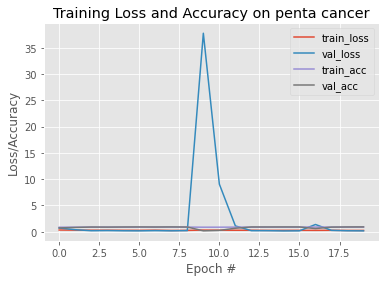

In [ ]:
model = VGG16.build(224,224, 3, 11)

print("[INFO] compiling model...")
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=20,
	steps_per_epoch=len(trainX) // 32, verbose=1)

# evaluate the network after initialization
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))
print("[INFO] re-compiling model...")
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] fine-tuning model...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=20,
	steps_per_epoch=len(trainX) // 32, verbose=1)

for key in H.history.keys():
    print(key)
# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))


# save the model to disk
print("[INFO] serializing model...")
model.save("output.model")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("output.png")

In [ ]:
!pip install flask-ngrok
!pip install flask_cors


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import Flask, app,request
from base64 import b64decode
import json
import os
import cv2
from imutils import paths
import base64
import numpy as np
import numpy
import sys
from flask import jsonify
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import requests
import pickle
from imutils.video import VideoStream
from imutils import paths
from threading import Thread
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from datetime import datetime
from datetime import date
import numpy as np
import argparse
import imutils
import pickle
import time
import cv2
import os
from base64 import b64decode
import base64
import io
from flask_cors import CORS, cross_origin


app = Flask(__name__)
cors = CORS(app)
run_with_ngrok(app)   #starts ngrok when the app is run
@app.route('/penta', methods=['GET','POST'])
# @cross_origin()
def login():
    # if request.method == 'POST':
    #   # print("called")
    result = input(request.json['uri'])
    print("sfvnvjknb")
    return result
    # print(request.json)
    



def input(uri):
    print("[INFO] loading model...")
    model = load_model(str("drive/MyDrive/20e.model"))
    imagePaths = list(paths.list_images("drive/MyDrive/penta_dataset/"))
    classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
    classNames = [str(x) for x in np.unique(classNames)]
    uri = uri
    header, encoded = uri.split(",", 1)
    data = b64decode(encoded)
    f = open("uriimage.png", "wb")
    f.write(data)
    frame = cv2.imread("uriimage.png")
    timestamp = datetime.now()
    frame = imutils.resize(frame, width=400)
    frame = cv2.flip(frame, 1)
    roi = cv2.resize(frame, (224, 224))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    proba = model.predict(roi)[0]
    label = classNames[proba.argmax()]
    print(label)
    return ({"data":label})
    # if the `q` key was pressed, break from the loop

if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a877f0b91636.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [18/Mar/2021 15:55:09] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:55:13] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:55:21] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:55:24] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:55:41] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:55:43] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:55:53] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:55:56] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:56:05] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:56:08] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:56:22] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:56:24] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:56:39] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:56:42] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:57:50] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:57:52] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:58:32] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:58:34] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 15:59:32] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 15:59:35] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:00:34] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:00:36] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:01:30] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:01:33] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:01:43] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:01:46] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:02:39] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:02:42] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:03:31] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:03:33] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:04:21] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:04:24] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:05:14] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:05:17] "POST /penta HTTP/1.1" 200 -


breast_normal
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:06:05] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:06:07] "POST /penta HTTP/1.1" 200 -


cervical_cancer
sfvnvjknb


127.0.0.1 - - [18/Mar/2021 16:06:16] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [18/Mar/2021 16:06:19] "POST /penta HTTP/1.1" 200 -


cervical_cancer
sfvnvjknb
